# Deep Learning Models

This is not a deep learning course, but by request, I will introduce simple examples to get started in deep learning and highlight some aspects that I find interesting. In particular, strategies for optimization and specialized architectures are not covered.

**Note**: This is a version for those of you on a Mac with AMD GPU - we can use the PlaidML backend to take advantage of the GPU. Note that this works with the standalone `keras`, not the tensorflow version.

First install

```
python3 -m pip install -U --quiet plaidml-keras plaidbench
```

Then run and choose the GPU as default device
```
plaidml-setup
```

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
os.environ['RUNFILES_DIR'] = '/usr/local/share/plaidml'
os.environ['PLAIDML_NATIVE_PATH'] = '/usr/local/lib/libplaidml.dylib'

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
import tensorflow as tf
import keras

Using plaidml.keras.backend backend.


In [6]:
from keras.utils import plot_model

In [7]:
import tensorflow_datasets as tfds

## Building models

### Prepare data

In [8]:
import seaborn as sns

In [9]:
iris = sns.load_dataset('iris')
iris.species = iris.species.astype('category').cat.codes
iris = iris.sample(frac=1)

In [10]:
X_train, y_train = iris.iloc[:, :-1].values, iris.iloc[:, -1].values

In [11]:
X_train = X_train.astype('float32')

### Pre-process data

If you need to pre-process your data, see https://keras.io/api/preprocessing/. We will not do any pre-processing for simplicity.

### Sequential API

If the entire pipeline is a single chain of layers, the Sequential API is the simplest to use.

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate

#### Set random seed for reproducibility

In [13]:
np.random.seed(0)
tf.random.set_seed(0)

In [14]:
X_train[0].shape

(4,)

In [15]:
model = Sequential()
model.add(Dense(8, input_shape=X_train[0].shape))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='softmax'))

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


**Alternative model specification**

```python
model = Sequential(
    Dense(8, input_shape=(4,)),
    Dense(4, activation='relu'),
    Dense(3, activation='softmax')
)
```

In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 15        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist = model.fit(
    X_train,
    y_train,
    validation_split = 0.3,
    epochs=50, 
    verbose=0)

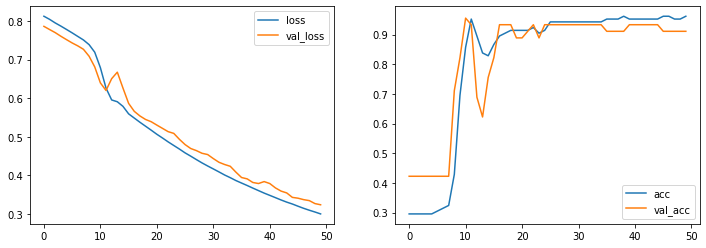

In [19]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'acc']):
    ax.plot(hist.history[measure], label=measure)
    ax.plot(hist.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass

In [20]:
plot_model(model)

In [21]:
from IPython.display import Image

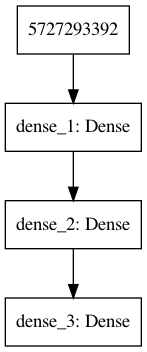

In [22]:
Image('model.png')

### Functional API

The functional API provides flexibility, allowing you to build models with multiple inputs, multiple outputs, or branch and merge architectures.

#### Set random seed for reproducibility

In [23]:
np.random.seed(0)
tf.random.set_seed(0)

In [24]:
input = Input(shape=(4,))
x = Dense(8)(input)
x = Dense(4, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=[input], outputs=[output])

In [25]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 15        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [27]:
hist = model.fit(
    X_train,
    y_train,
    validation_split = 0.3,
    epochs=50, 
    verbose=0)

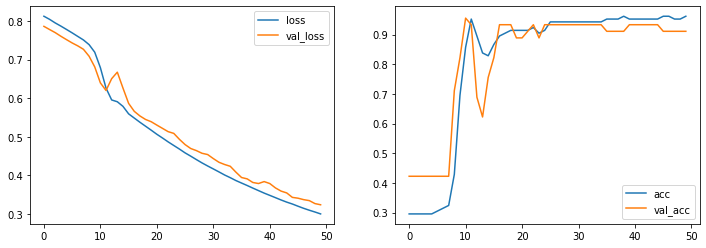

In [28]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'acc']):
    ax.plot(hist.history[measure], label=measure)
    ax.plot(hist.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass

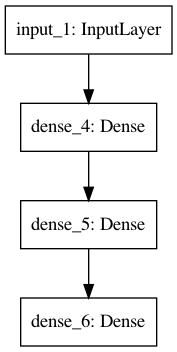

In [29]:
plot_model(model)
Image('model.png')

#### Flexibility of functional API

You can easily implement multiple inputs, multiple outputs or skip connections. Note that if you have multiple outputs, you probably also want multiple loss functions given as a list in the compile step (unless the same loss function is applicable to both outputs).

In [30]:
input = Input(shape=(4,))
x1 = Dense(8)(input)
x2 = Dense(4, activation='relu')(x1)
x3 = concatenate([input, x2])
output = Dense(3, activation='softmax')(x3)
model = Model(inputs=[input], outputs=[output])

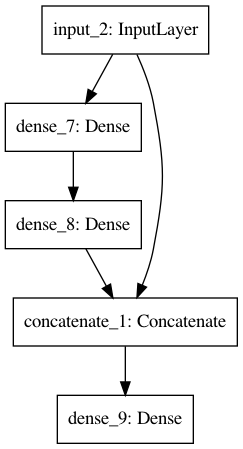

In [31]:
plot_model(model)
Image('model.png')

## Hyperparameter optimization

In [32]:
import optuna

In [33]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

In [34]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [35]:
class Objective(object):
    def __init__(self, X, y, 
                 max_epochs, 
                 input_shape, 
                 num_classes):
        self.X = X
        self.y = y
        self.max_epochs = max_epochs
        self.input_shape = input_shape
        self.num_classes = num_classes
 
    def __call__(self, trial):        
        dropout=trial.suggest_discrete_uniform('dropout', 0.05, 0.5, 0.05)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 96, 128])
                      
        params = dict(
            dropout = dropout,
            batch_size = batch_size
        )
            
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=self.input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(params['dropout']))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(params['dropout']))
        model.add(Dense(self.num_classes, activation='softmax'))
            
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])                 
             
        # fit the model
        hist = model.fit(x=self.X, y=self.y,
                          batch_size=params['batch_size'],
                          validation_split=0.25,
                          epochs=self.max_epochs)
                 
        loss = np.min(hist.history['val_loss'])
                 
        return loss

In [36]:
optuna.logging.set_verbosity(0)

In [37]:
N = 5
max_epochs = 3
input_shape = (28,28,1)
num_classes = 10

In [38]:
%%time

objective1 = Objective(X_train, y_train, max_epochs, input_shape, num_classes)
study1 = optuna.create_study(direction='minimize')
study1.optimize(objective1, n_trials=N)

Train on 45000 samples, validate on 15000 samples
Epoch 1/3
45000/45000 [==============================] - 19s 430us/step - loss: 0.2965 - acc: 0.9088 - val_loss: 0.0837 - val_acc: 0.9749
Epoch 2/3
45000/45000 [==============================] - 19s 420us/step - loss: 0.1083 - acc: 0.9680 - val_loss: 0.0569 - val_acc: 0.9825
Epoch 3/3
45000/45000 [==============================] - 19s 415us/step - loss: 0.0829 - acc: 0.9752 - val_loss: 0.0493 - val_acc: 0.9859
Train on 45000 samples, validate on 15000 samples
Epoch 1/3
45000/45000 [==============================] - 23s 504us/step - loss: 0.2049 - acc: 0.9371 - val_loss: 0.0688 - val_acc: 0.9793
Epoch 2/3
45000/45000 [==============================] - 19s 423us/step - loss: 0.0540 - acc: 0.9838 - val_loss: 0.0469 - val_acc: 0.9861
Epoch 3/3
45000/45000 [==============================] - 19s 418us/step - loss: 0.0357 - acc: 0.9887 - val_loss: 0.0511 - val_acc: 0.9844
Train on 45000 samples, validate on 15000 samples
Epoch 1/3
45000/45000 

In [40]:
df = study1.trials_dataframe()

In [41]:
df.head()

number     value             datetime_start          datetime_complete  \
0       0  0.049347 2020-10-21 08:34:48.712812 2020-10-21 08:35:45.753741   
1       1  0.046897 2020-10-21 08:35:45.753777 2020-10-21 08:36:46.349771   
2       2  0.052158 2020-10-21 08:36:46.349811 2020-10-21 08:37:51.400444   
3       3  0.044622 2020-10-21 08:37:51.400485 2020-10-21 08:38:52.037658   
4       4  0.043021 2020-10-21 08:38:52.037701 2020-10-21 08:40:05.707299   

                duration  params_batch_size  params_dropout     state  
0 0 days 00:00:57.040929                128            0.50  COMPLETE  
1 0 days 00:01:00.595994                128            0.15  COMPLETE  
2 0 days 00:01:05.050633                 96            0.15  COMPLETE  
3 0 days 00:01:00.637173                128            0.20  COMPLETE  
4 0 days 00:01:13.669598                 64            0.45  COMPLETE

In [42]:
from optuna.visualization import plot_param_importances

In [44]:
plot_param_importances(study1)